# Simulate Reads

How many reads do we need to detect N clusters at varying levels of abundance with varying number of modifications present.

Variables:
* Number of read classes
* Number of reads in each class
* Similarity to other read classes aka How many modification sites differ
* What is the accuracy for each modification

Thoughts / Sticking points:

Some mods are not independent so how do we model non-independent mods? Include them and just forget about it? Map them together into a single mod? Exclude from analysis? How do we determine if a cluster is "Good". What clustering algorithm should we use? Can we generate several simulations and then see which clustering algorithm does best? I think yes. 


1: Generate random reads profiles from mod profile and prediction accuracy  
2: Create Simulation Framework

In [366]:
import numpy as np
import pandas as pd
import os
from read_clustering.variant_call import VariantCalls
threshold = 0.5
np.random.seed(42)

In [38]:
def generate_call_from_fraction_correct(label, fraction_correct, n=1):
    p = np.random.random(n)
    if label:
        return (p <= fraction_correct).astype(int)
    else:
        return (p > fraction_correct).astype(int)

def generate_call_from_sample_of_probs(sampling_of_probs, n=1):
    return np.random.choice(sampling_of_probs, n)    

In [426]:
print(np.average(generate_call_from_fraction_correct(1, 0.1, 10000)))
print(np.average(generate_call_from_fraction_correct(0, 0.9, 10000)))

0.1074
0.1005


In [425]:
dist = generate_call_from_fraction_correct(1, 0.1, 10000)
print(np.average(dist))
print(np.average(generate_call_from_sample_of_probs(dist, 10000)))

0.1012
0.0986


In [394]:
accuracy_csv = "/Users/andrewbailey/Desktop/1_per_position_data_0.5.csv"
accuracy_csv = "/Volumes/gdrive/rrna_kube_testing/small_5mer/test/train_500_test_500_prob_0.7_em_iterations_30_gaussian_true_FREQ_THRESHOLD_0_USE_IVT_TRAINING_true_unsupervised_false_all_kmers_false_small_model_5mer_use_median_true/testing_accuracy_csvs/30_per_position_data_0.5.csv"


In [395]:
accuracy_data = pd.read_csv(accuracy_csv)


In [428]:
accuracy_data = pd.read_csv(accuracy_csv)
acc_df = accuracy_data[["contig", "reference_index", "strand"]]
index = pd.MultiIndex.from_frame(acc_df)
mod_map = [1 for x in range(len(acc_df)-3)] + [0, 0, 0]
accuracy_key = "accuracy"
n=10

In [432]:
mod_calls = []
for i, x in enumerate(mod_map):
    key = "recall"
    if x == 0:
        key = "specificity"
    mod_calls.append(generate_call_from_fraction_correct(x, accuracy_data[key][i], n))
data = np.array(mod_calls)


In [433]:
data

array([[0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [443]:
class SimulateModProbs(object):
    def __init__(self, accuracy_csv):
        self.accuracy_data = pd.read_csv(accuracy_csv)
        self.acc_df = accuracy_data[["contig", "reference_index", "strand"]]
        self.index = pd.MultiIndex.from_frame(acc_df)

#     def get_simulated_data(self, mod_map, accuracy_key="accuracy", n=100):
#         mod_accuracy_map = zip(mod_map, accuracy_data[accuracy_key])
#         data = np.array([generate_call_from_fraction_correct(mod, accuracy, n) for mod, accuracy in mod_accuracy_map])
#         return pd.DataFrame(data.T, columns=self.index)
    
    def get_simulated_data(self, mod_map, n=100):
        mod_calls = []
        for i, x in enumerate(mod_map):
            key = "recall"
            if x == 0:
                key = "specificity"
            mod_calls.append(generate_call_from_fraction_correct(x, accuracy_data[key][i], n))
        return pd.DataFrame(np.array(mod_calls).T, columns=self.index) 

    
    def generate_variant_calling_output(self, mod_map, accuracy_key="accuracy", n=100):
        df = self.get_simulated_data(mod_map, n=n)
        df.index.rename("read_id", inplace=True)
        df1 = df.melt(ignore_index=False)
        df1.rename(columns={"value": "prob2"}, inplace=True)
        df1.loc[:, "prob1"] = 1-df1["prob2"]
        df1.reset_index(inplace=True)
        return df1

In [398]:
simulation_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/simulation/test"
smp = SimulateModProbs(accuracy_csv)

In [466]:
n = 100
mod_map = [1 for x in range(len(acc_df))]
df1 = smp.generate_variant_calling_output(mod_map, n=n)
out_path = os.path.join(simulation_path, "test.csv")
df1.to_csv(out_path, index=False)

In [467]:
n = 100
mod_map2 = [1 if x > 1 else 0 for x in range(len(acc_df))]
df1 = smp.generate_variant_calling_output(mod_map2, n=n)
out_path2 = os.path.join(simulation_path, "test2.csv")
df1.to_csv(out_path2, index=False)

In [468]:
ivt_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/canonical_ivt_round30_alt_canonical_supervised_500_500.model.csv"
cbf5_glu_psu_depletion_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/depletion_cbf5_glu_round30_alt_canonical_supervised_500_500.model.csv"
nop58_glu_2o_depletion_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/depletion_nop58_glu_round30_alt_canonical_supervised_500_500.model.csv"       
native_cbf5_gal_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/native_cbf5_gal_round30_alt_canonical_supervised_500_500.model.csv"
native_nop58_gal_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/native_nop58_gal_round30_alt_canonical_supervised_500_500.model.csv"

file_paths = [out_path2]
labels = ["one_off"]

file_paths = [out_path, out_path2]
labels = ["test", "one_off"]
# file_paths = [ivt_path, cbf5_glu_psu_depletion_path, nop58_glu_2o_depletion_path, native_cbf5_gal_path, native_nop58_gal_path]
# labels = ["ivt", "cbf5_glu_psu_depletion", "nop58_glu_2o_depletion", "native_cbf5_gal", "native_nop58_gal"]

In [469]:
vc = VariantCalls(file_paths, labels)


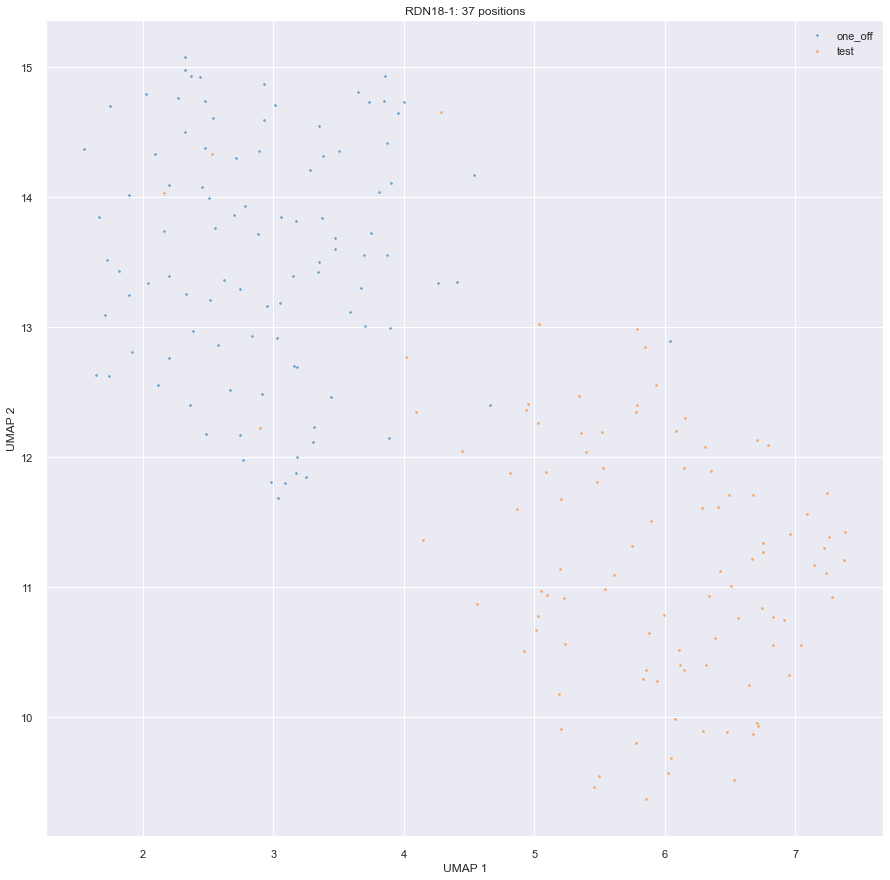

In [470]:
contig = 'RDN18-1'
n_components = 2
save_fig_path=None
vc.plot_UMAP_by_label(contig, vc.get_contig_positions(contig), n_components=n_components, figure_path=save_fig_path)

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

KeyError: 'variants'

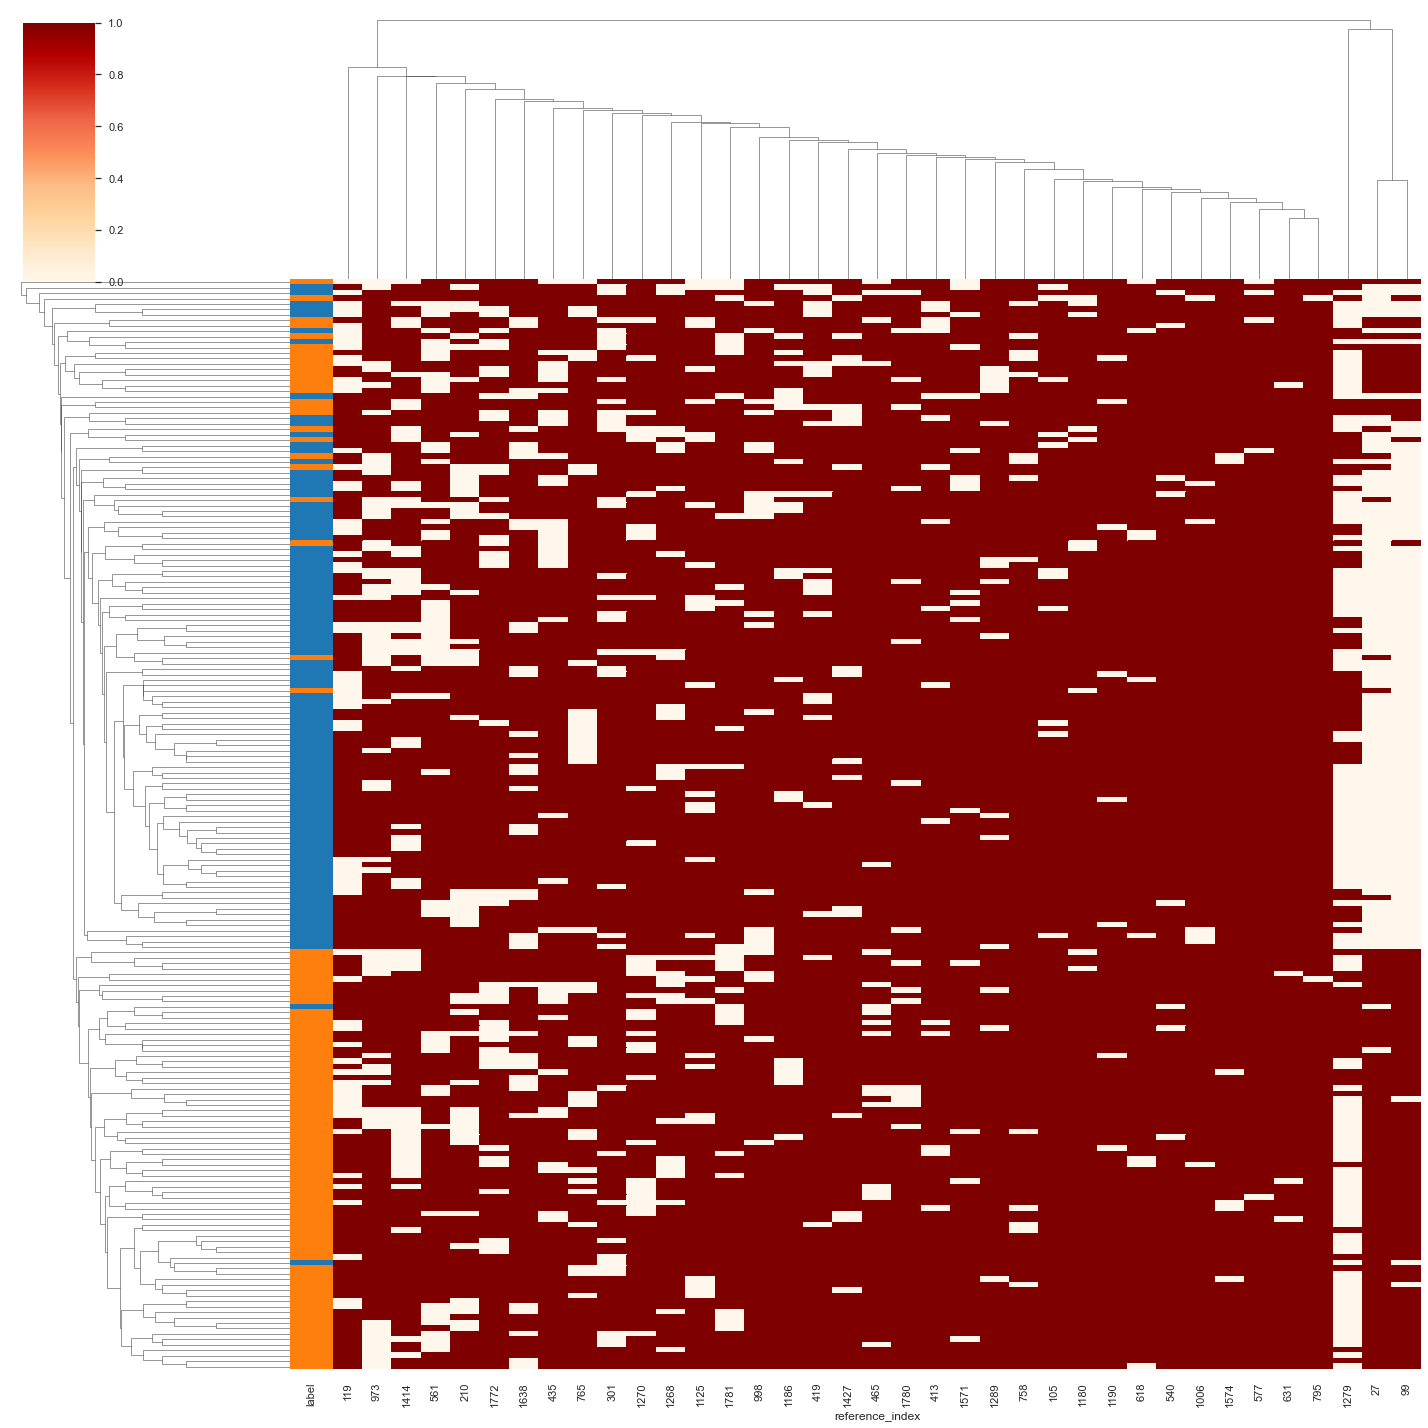

In [471]:
n=-1
figure_path = None
vc.plot_heatmap_dendrogram(contig, vc.get_contig_positions(contig), n=n, figure_path=figure_path)
